## UFC Fight-level dataset SVM, SGD & NN Notebook
(thre is no quick rule as to which kernel performs best in every scenario; testing & learning is key)

Kernel trick reference:
https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d

#### Import necessary modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from keras.layers import Input, Lambda, Dense, Dropout
from keras.models import Model, Sequential
from keras import optimizers
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam, Adamax, Adadelta
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})
%matplotlib inline

/Users/colella2/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/colella2/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/colella2/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/colella2/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

#### Helper functions

In [2]:
# rtns best params for C and Gamma; they are the parameters for a nonlinear support vector machine

def svc_parameter_optimization(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10] # C is trade off betw. low train error and low test error (ability to generalize) 
    gammas = [0.001, 0.01, 0.1, 1] # free parameter of the Gaussian radial basis function
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds) # instantiate grid search
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

#### Set working directory

In [3]:
os.chdir(r'/Users/colella2/Google Drive/Graduate School/MScA/Courses/31008 Data Mining Principles/Final_Project/msca31008/fun/')

In [4]:
pwd

'/Users/colella2/Google Drive/Graduate School/MScA/Courses/31008 Data Mining Principles/Final_Project/msca31008/fun'

In [5]:
os.listdir('../fun/') # confirm items in function folder

['.DS_Store',
 'r.py',
 'tonum.py',
 'hierarchical_imputation.py',
 'fillna-kmeans.py',
 'settings.py',
 'pkl.py',
 'spl.py',
 'untitled',
 'ddict.py']

In [6]:
exec(open('r.py').read()) # test ability to read .py script from function folder

In [7]:
# read-in all the functions
for filename in os.listdir('../fun/'):
    if filename.endswith('.py'):
        exec(open(filename).read())
        continue
    else:
        continue

#### Open file of interest

In [8]:
os.chdir(r'/Users/colella2/Google Drive/Graduate School/MScA/Courses/31008 Data Mining Principles/Final_Project/msca31008/out_colella')

with open('d3-fight-level-transform.pkl', 'rb') as f:
    data = pickle.load(f)

In [9]:
load( '../out_colella/d3-fight-level-transform.pkl' ) # 166 colummns means it has the odds included
print( X.shape )

(4091, 166)


#### Examine key-value pairs in dict

In [10]:
for key, value in data.items():
  print(key, value)

X [[ 2.99245499e-01 -9.97010194e-02  2.55070204e-01 ... -4.09859262e-03
   2.58857981e-03  4.18117087e-04]
 [ 2.53311260e-01 -1.17794088e-01  2.16182739e-01 ...  2.96931364e-03
   1.22945903e-03  2.02198147e-03]
 [-1.95787955e-03 -2.41615241e-03 -2.14019170e-03 ...  6.99605205e-01
   8.14480882e-05  3.52400264e-04]
 ...
 [-9.22256998e-03 -1.41063038e-01 -1.42829888e-01 ... -1.44873339e-03
   4.52071743e-04 -1.41618555e-04]
 [-9.92344076e-03 -1.51146060e-01 -1.53186378e-01 ... -1.17141188e-03
   1.52298831e-03  2.24250468e-04]
 [-1.01669412e-02 -1.52613336e-01 -1.55193463e-01 ... -1.54915223e-03
   9.77677784e-04  2.37751371e-04]]
y 0       1
1       1
2       1
3       0
4       0
       ..
4086    1
4087    1
4088    1
4089    1
4090    1
Name: Winner, Length: 4091, dtype: int64
cols Index(['title_bout', 'weight_class', 'no_of_rounds', 'date_year', 'date_month', 'date_dayofmonth', 'date_dayofweek', 'date_frisat', 'womens', 'weight_class_catch_weight',
       ...
       'Mean_avg_opp_H

In [11]:
print(X.shape) # view feature shape; 4368 rows, 165 columns

(4091, 166)


In [12]:
print(y.shape) # view predicted value shape; 4368 rows, 1 column

(4091,)


#### Train-test split

In [13]:
X_train , X_test, y_train, y_test = train_test_split(X, y, random_state = 718, test_size = 0.3)

### SVM

#### Fit model (linear kernel)
(find decision boundary for linearly separable data)

In [15]:
svclassifier_linear = SVC(kernel='linear')
svclassifier_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [16]:
# accuracy against train data: 72%
print(classification_report(y_train,svclassifier_linear.predict(X_train)))

              precision    recall  f1-score   support

           0       0.69      0.33      0.44       963
           1       0.73      0.92      0.82      1900

    accuracy                           0.72      2863
   macro avg       0.71      0.63      0.63      2863
weighted avg       0.72      0.72      0.69      2863



In [17]:
# accuracy against test data: 68%
print(classification_report(y_test, svclassifier_linear.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.28      0.37       425
           1       0.70      0.89      0.78       803

    accuracy                           0.68      1228
   macro avg       0.63      0.58      0.58      1228
weighted avg       0.65      0.68      0.64      1228



In [18]:
# store predicted values on X_test & print confusion matrix
y_pred_linear = svclassifier_linear.predict(X_test)
print(confusion_matrix(y_test,y_pred_linear))

[[118 307]
 [ 90 713]]


### Begin section for non-linear investigation

#### Fit model (poly kernel)

In [63]:
svclassifier_poly = SVC(kernel='poly', degree=8)
svclassifier_poly.fit(X_train, y_train)

/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=8, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [64]:
# accuracy against train data: 66%
print(classification_report(y_train,svclassifier_poly.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       963
           1       0.66      1.00      0.80      1900

    accuracy                           0.66      2863
   macro avg       0.33      0.50      0.40      2863
weighted avg       0.44      0.66      0.53      2863



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
# accuracy against test data 65%
print(classification_report(y_test, svclassifier_poly.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       425
           1       0.65      1.00      0.79       803

    accuracy                           0.65      1228
   macro avg       0.33      0.50      0.40      1228
weighted avg       0.43      0.65      0.52      1228



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
# store predicted values on X_test & print confusion matrix
y_pred_poly = svclassifier_poly.predict(X_test)
print(confusion_matrix(y_test,y_pred_poly))

[[  0 425]
 [  0 803]]


#### Fit model (Gaussian kernel)
(this is a special case for rbf)

In [67]:
svclassifier_gaus = SVC(kernel='rbf')
svclassifier_gaus.fit(X_train, y_train)

/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [68]:
# accuracy against train data: 66%
print(classification_report(y_train,svclassifier_gaus.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       963
           1       0.66      1.00      0.80      1900

    accuracy                           0.66      2863
   macro avg       0.33      0.50      0.40      2863
weighted avg       0.44      0.66      0.53      2863



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
# accuracy against test data: 65%
print(classification_report(y_test, svclassifier_gaus.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       425
           1       0.65      1.00      0.79       803

    accuracy                           0.65      1228
   macro avg       0.33      0.50      0.40      1228
weighted avg       0.43      0.65      0.52      1228



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
# store predicted values on X_test & print confusion matrix
y_pred_gaus = svclassifier_gaus.predict(X_test)
print(confusion_matrix(y_test,y_pred_gaus))

[[  0 425]
 [  0 803]]


#### After first running simply (as was done above), commence optimization...

In [71]:
# commence grid search for best parameters on training set
svc_parameter_optimization(X_train, y_train, 5)

{'C': 10, 'gamma': 0.1}

In [72]:
# instantiate with optimal parameters
svclassifier_gaus_optim = SVC(kernel='rbf', C = 1, gamma = 1)
svclassifier_gaus_optim.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [73]:
# view optimized results/accuracy on training data: 83%
print(classification_report(y_train,svclassifier_gaus_optim.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.54      0.69       963
           1       0.81      0.98      0.89      1900

    accuracy                           0.83      2863
   macro avg       0.87      0.76      0.79      2863
weighted avg       0.85      0.83      0.82      2863



In [74]:
# view optimized results/accuracy on testing data: 68%
print(classification_report(y_test, svclassifier_gaus_optim.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.24      0.34       425
           1       0.69      0.91      0.79       803

    accuracy                           0.68      1228
   macro avg       0.63      0.57      0.56      1228
weighted avg       0.65      0.68      0.63      1228



In [75]:
# store predicted values on X_test & print confusion matrix
y_pred_gaus_optim = svclassifier_gaus_optim.predict(X_test)
print(confusion_matrix(y_test,y_pred_gaus_optim))

[[102 323]
 [ 75 728]]


#### Fit model (Sigmoid kernel)
(suitable for binary classification problems; rtns 0 or 1; activation functino for Neural Networks)

In [76]:
svclassifier_sig = SVC(kernel='sigmoid')
svclassifier_sig.fit(X_train, y_train)

/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [77]:
# accuracy against train data: 66%
print(classification_report(y_train,svclassifier_sig.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       963
           1       0.66      1.00      0.80      1900

    accuracy                           0.66      2863
   macro avg       0.33      0.50      0.40      2863
weighted avg       0.44      0.66      0.53      2863



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
# accuracy against test data: 65%
print(classification_report(y_test, svclassifier_sig.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       425
           1       0.65      1.00      0.79       803

    accuracy                           0.65      1228
   macro avg       0.33      0.50      0.40      1228
weighted avg       0.43      0.65      0.52      1228



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
# store predicted values on X_test & print confusion matrix
y_pred_sig = svclassifier_sig.predict(X_test)
print(confusion_matrix(y_test,y_pred_sig))

[[  0 425]
 [  0 803]]


#### Conclusion
Linear SVM performs similarly to optimized Gaussian RBF on test sets.

### SGD

In [19]:
# instantiate SGD classifier
linear_sgd_classifier = SGDClassifier(random_state = 0)

In [20]:
# instantiate the GridSearchCV object and run search
params = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 'loss':['hinge', 'log'], 'penalty':['l1','l2']}

grid_search = GridSearchCV(linear_sgd_classifier, params, cv = 5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, ret

In [21]:
# best parameters & the corresponding score
print("Best CV params", grid_search.best_params_)
print("Best CV accuracy", grid_search.best_score_)
print("Test accuracy of best grid search hypers:", grid_search.score(X_test, y_test))

Best CV params {'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'}
Best CV accuracy 0.6919315403422983
Test accuracy of best grid search hypers: 0.6864820846905537


In [22]:
%%time

# fit SGD classifier
linear_sgd_classifier.fit(X_train, y_train)

CPU times: user 54.3 ms, sys: 1.17 ms, total: 55.5 ms
Wall time: 55 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
# accuracy against train data: 73%
print(classification_report(y_train, linear_sgd_classifier.predict(X_train)))

              precision    recall  f1-score   support

           0       0.65      0.42      0.51       963
           1       0.75      0.88      0.81      1900

    accuracy                           0.73      2863
   macro avg       0.70      0.65      0.66      2863
weighted avg       0.72      0.73      0.71      2863



In [24]:
# accuracy against test data: 68%
print(classification_report(y_test, linear_sgd_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.55      0.38      0.45       425
           1       0.72      0.84      0.77       803

    accuracy                           0.68      1228
   macro avg       0.64      0.61      0.61      1228
weighted avg       0.66      0.68      0.66      1228



As one can see, the accuracy on the test set is 0.65, matching Gaussian-RBD and linear SVM. It also better precision and recall than optimized Gaussian-RBF & matches or betters linear SVM. It matches linear SVM on recall.

### Neural Network
ReLu activation function for hidden layers.
Sigmoid activation function for binary classification. CAUTION: Large neural nets trained on relatively small datasets can overfit the training data. Generalization error increases due to overfitting.

#### Instance 1
3 layers of 55 nodes/neurons/perceptrons mapping to 1 target variable

In [25]:
# instantiate classifier
classifier = Sequential()

# optimal size of the hidden layer is usually between the size of the input and size of the output layers
# general rule I used was # input features of 165 / # hidden layers = # nodes per layer

# ReLu is based on principle that linear models are easier to optimize
# random normal initializer generates tensors with a normal distribution

# hidden layer 1 - # of neurons comprising this layer is equal to number of features
classifier.add(Dense(55, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 166))

# hidden layer 2
classifier.add(Dense(55, activation = 'relu', kernel_initializer = 'random_normal'))

# hidden layer 3
classifier.add(Dense(55, activation = 'relu', kernel_initializer = 'random_normal'))

# output layer
# single node for classification unless softmax is used -- then one node per class label
# Sigmoid function is the special case of Softmax function where the number of classes are 2
classifier.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

In [26]:
# compile NN
classifier.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics = ['accuracy'])

# use Adam optimization -- "adaptive moment estimation"; it's a combo of RMSProp + Momentum



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
%%time

# fit training data to model
# batch size 55 means 55 samples per gradient update AKA # of patterns shown to NN before weights updated
# also training optimization -- how many patterns to read at a time and keep in memory

# train w/ 60 epochs -- epoch is an iteration over entire data set
classifier.fit(X_train, y_train, batch_size = 55, epochs = 60)


Epoch 1/60
2863/2863 [==============================] - 1s 377us/step - loss: 0.6634 - acc: 0.6633
Epoch 2/60
2863/2863 [==============================] - 0s 54us/step - loss: 0.6045 - acc: 0.6636
Epoch 3/60
2863/2863 [==============================] - 0s 56us/step - loss: 0.5738 - acc: 0.6636
Epoch 4/60
2863/2863 [==============================] - 0s 58us/step - loss: 0.5533 - acc: 0.6846
Epoch 5/60
2863/2863 [==============================] - 0s 55us/step - loss: 0.5350 - acc: 0.7251
Epoch 6/60
2863/2863 [==============================] - 0s 55us/step - loss: 0.5246 - acc: 0.7436
Epoch 7/60
2863/2863 [==============================] - 0s 55us/step - loss: 0.5039 - acc: 0.7538
Epoch 8/60
2863/2863 [==============================] - 0s 58us/step - loss: 0.4834 - acc: 0.7786
Epoch 9/60
2863/2863 [==============================] - 0s 62us/step - loss: 0.4646 - acc: 0.7873
Epoch 10/60
2863/2863 [==============================] - 0s 64us/step - loss: 0.4356 - acc: 0.8089
Epoch 11/60
2863/

In [28]:
# evaluate loss & metrics values for model
classifier.evaluate(X_train, y_train) # accuracy near 100% on training data, which is a sign of overfitting

2863/2863 [==============================] - 0s 72us/step


[0.0007395107846847308, 1.0]

In [29]:
# predict on test data
# if prediction is greater than 0.5, output is 1; otherwise, output is 0
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [30]:
# accuracy on test: ~63%
confusion_matrix(y_test, y_pred) # TP + TN = 778; 778/1228 total = ~63% accurate

array([[193, 232],
       [218, 585]])

#### Instance 2
5 layers of 33 nodes mapping to 1 target variable

2 additional layers introduced b/c, empirically, deep NN's perform better

In [31]:
# instantiate classifier 2
classifier_2 = Sequential()

# hidden layer 1
classifier_2.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 166))

# hidden layer 2
classifier_2.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))

# hidden layer 3
classifier_2.add(Dense(33, activation ='relu', kernel_initializer = 'random_normal'))

# hidden layer 4
classifier_2.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))

# hidden layer 5
classifier_2.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))

# output layer
classifier_2.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

In [32]:
# compile NN
classifier_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
%%time

# fit training data to model
classifier_2.fit(X_train, y_train, batch_size = 15, epochs = 70)

Epoch 1/70
2863/2863 [==============================] - 2s 550us/step - loss: 0.6395 - acc: 0.6633
Epoch 2/70
2863/2863 [==============================] - 0s 148us/step - loss: 0.5723 - acc: 0.6636
Epoch 3/70
2863/2863 [==============================] - 0s 141us/step - loss: 0.5508 - acc: 0.6993
Epoch 4/70
2863/2863 [==============================] - 0s 136us/step - loss: 0.5382 - acc: 0.7202
Epoch 5/70
2863/2863 [==============================] - 0s 134us/step - loss: 0.5254 - acc: 0.7248
Epoch 6/70
2863/2863 [==============================] - 0s 137us/step - loss: 0.5106 - acc: 0.7485
Epoch 7/70
2863/2863 [==============================] - 0s 133us/step - loss: 0.4927 - acc: 0.7628
Epoch 8/70
2863/2863 [==============================] - 0s 134us/step - loss: 0.4707 - acc: 0.7831
Epoch 9/70
2863/2863 [==============================] - 0s 136us/step - loss: 0.4397 - acc: 0.8030
Epoch 10/70
2863/2863 [==============================] - 0s 135us/step - loss: 0.4087 - acc: 0.8177
Epoch 11/

In [34]:
# evaluate loss & metrics values for model
classifier_2.evaluate(X_train, y_train) # accuracy near 94% on training data, which is also a sign of overfitting

2863/2863 [==============================] - 0s 80us/step


[0.17248240788052477, 0.9399231575270695]

In [35]:
# predict on test data
# if prediction is greater than 0.5, output is 1; otherwise, output is 0
y_pred_2 = classifier_2.predict(X_test)
y_pred_2 = (y_pred_2 > 0.5)

In [36]:
# accuracy on test: ~62%
confusion_matrix(y_test, y_pred_2) # TP + TN = 761; 761/1228 total = ~62% accurate

array([[237, 188],
       [279, 524]])

#### Instance 3 -- tackle overfitting during model training
5 layers of 33 nodes mapping to 1 target variable

In [37]:
# instantiate classifier 3
classifier_3 = Sequential()

Implementation of dropout regularization to approximate training a large # of NN's w/ unique architectures in parallel, which we don't have the time or compute for.

In [38]:
# hidden layer 1
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 166))
classifier_3.add(Dropout(0.1))

# hidden layer 2
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_3.add(Dropout(0.1))

# hidden layer 3
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_3.add(Dropout(0.1))

# hidden layer 4
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_3.add(Dropout(0.1))

# hidden layer 5
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_3.add(Dropout(0.1))

# output layer
classifier_3.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [39]:
# compile NN
classifier_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [40]:
%%time

# fit training data to model
classifier_3.fit(X_train,y_train, batch_size = 15, epochs = 60)

Epoch 1/60
2863/2863 [==============================] - 2s 762us/step - loss: 0.6423 - acc: 0.6629
Epoch 2/60
2863/2863 [==============================] - 1s 212us/step - loss: 0.5809 - acc: 0.6636
Epoch 3/60
2863/2863 [==============================] - 1s 207us/step - loss: 0.5524 - acc: 0.6856
Epoch 4/60
2863/2863 [==============================] - 1s 211us/step - loss: 0.5400 - acc: 0.7258
Epoch 5/60
2863/2863 [==============================] - 1s 211us/step - loss: 0.5246 - acc: 0.7324
Epoch 6/60
2863/2863 [==============================] - 1s 209us/step - loss: 0.5100 - acc: 0.7590
Epoch 7/60
2863/2863 [==============================] - 1s 211us/step - loss: 0.4923 - acc: 0.7621
Epoch 8/60
2863/2863 [==============================] - 1s 211us/step - loss: 0.4714 - acc: 0.7859
Epoch 9/60
2863/2863 [==============================] - 1s 210us/step - loss: 0.4418 - acc: 0.8041
Epoch 10/60
2863/2863 [==============================] - 1s 211us/step - loss: 0.4297 - acc: 0.8163
Epoch 11/

In [41]:
# evaluate loss & metrics values for model
classifier_3.evaluate(X_train, y_train) # accuracy near 94% on training data

2863/2863 [==============================] - 0s 131us/step


[0.057680996462125024, 0.9863779252532309]

In [42]:
# predict on test data
# if prediction is greater than 0.5, output is 1; otherwise, output is 0
y_pred_3 = classifier_3.predict(X_test)
y_pred_3 = (y_pred_3 > 0.5)

In [43]:
# accuracy on test: ~66%
confusion_matrix(y_test, y_pred_3) # TP + TN = 806; 806/1228 total = ~66% accurate

array([[159, 266],
       [156, 647]])

#### Instance 4
11 layers of 15 nodes mapping to 1 target variable

In [44]:
# instantiate classifier 4
classifier_4 = Sequential()

In [45]:
# hidden layer 1
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 166))
classifier_4.add(Dropout(0.1))

# hidden layer 2
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 3
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 4
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 5
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 6
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 7
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 8
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 9
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 10
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 11
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# output layer
classifier_4.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

In [46]:
# compile NN
classifier_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [47]:
%%time

# fit training data to model
classifier_4.fit(X_train,y_train, batch_size = 15, epochs = 200)

Epoch 1/200
2863/2863 [==============================] - 4s 1ms/step - loss: 0.6600 - acc: 0.6612
Epoch 2/200
2863/2863 [==============================] - 1s 308us/step - loss: 0.6384 - acc: 0.6636
Epoch 3/200
2863/2863 [==============================] - 1s 321us/step - loss: 0.5989 - acc: 0.6636
Epoch 4/200
2863/2863 [==============================] - 1s 307us/step - loss: 0.5720 - acc: 0.6636
Epoch 5/200
2863/2863 [==============================] - 1s 310us/step - loss: 0.5647 - acc: 0.6636
Epoch 6/200
2863/2863 [==============================] - 1s 309us/step - loss: 0.5563 - acc: 0.6636
Epoch 7/200
2863/2863 [==============================] - 1s 311us/step - loss: 0.5568 - acc: 0.6636
Epoch 8/200
2863/2863 [==============================] - 1s 314us/step - loss: 0.5462 - acc: 0.6636
Epoch 9/200
2863/2863 [==============================] - 1s 311us/step - loss: 0.5429 - acc: 0.6832
Epoch 10/200
2863/2863 [==============================] - 1s 312us/step - loss: 0.5382 - acc: 0.6825
E

2863/2863 [==============================] - 1s 313us/step - loss: 0.3753 - acc: 0.8163
Epoch 83/200
2863/2863 [==============================] - 1s 318us/step - loss: 0.3881 - acc: 0.8020
Epoch 84/200
2863/2863 [==============================] - 1s 322us/step - loss: 0.3864 - acc: 0.8145
Epoch 85/200
2863/2863 [==============================] - 1s 315us/step - loss: 0.3717 - acc: 0.8187
Epoch 86/200
2863/2863 [==============================] - 1s 312us/step - loss: 0.3713 - acc: 0.8177
Epoch 87/200
2863/2863 [==============================] - 1s 309us/step - loss: 0.3727 - acc: 0.8191
Epoch 88/200
2863/2863 [==============================] - 1s 305us/step - loss: 0.3663 - acc: 0.8222
Epoch 89/200
2863/2863 [==============================] - 1s 306us/step - loss: 0.3694 - acc: 0.8187
Epoch 90/200
2863/2863 [==============================] - 1s 314us/step - loss: 0.3621 - acc: 0.8243
Epoch 91/200
2863/2863 [==============================] - 1s 312us/step - loss: 0.3683 - acc: 0.8212
Epo

2863/2863 [==============================] - 1s 319us/step - loss: 0.3140 - acc: 0.8530
Epoch 163/200
2863/2863 [==============================] - 1s 319us/step - loss: 0.3160 - acc: 0.8519
Epoch 164/200
2863/2863 [==============================] - 1s 315us/step - loss: 0.3019 - acc: 0.8634
Epoch 165/200
2863/2863 [==============================] - 1s 312us/step - loss: 0.3057 - acc: 0.8568
Epoch 166/200
2863/2863 [==============================] - 1s 311us/step - loss: 0.3128 - acc: 0.8530
Epoch 167/200
2863/2863 [==============================] - 1s 312us/step - loss: 0.3048 - acc: 0.8571
Epoch 168/200
2863/2863 [==============================] - 1s 313us/step - loss: 0.2945 - acc: 0.8624
Epoch 169/200
2863/2863 [==============================] - 1s 308us/step - loss: 0.3093 - acc: 0.8585
Epoch 170/200
2863/2863 [==============================] - 1s 302us/step - loss: 0.2990 - acc: 0.8596
Epoch 171/200
2863/2863 [==============================] - 1s 308us/step - loss: 0.3015 - acc: 0

In [48]:
# evaluate loss & metrics values for model
classifier_4.evaluate(X_train, y_train) # accuracy near 91% on training data

2863/2863 [==============================] - 1s 217us/step


[0.24273370069471473, 0.8969612295212048]

In [49]:
# predict on test data
# if prediction is greater than 0.5, output is 1; otherwise, output is 0
y_pred_4 = classifier_4.predict(X_test)
y_pred_4 = (y_pred_4 > 0.5)

In [50]:
# accuracy on test: ~63%
confusion_matrix(y_test, y_pred_4) # TP + TN = 778; 778/1228 total = ~63% accurate

array([[249, 176],
       [274, 529]])

#### Instance 5

Grid Search w/ Keras Classifier & 5-fold CV (Adam optimization)

In [51]:
# function to create model

def classifier_model():
    
    # create model
    model = Sequential()
    
    # hidden layer 1
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 166))
    model.add(Dropout(0.1))

    # hidden layer 2
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 3
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 4
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 5
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # output layer
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [52]:
# instantiate keras classifier model -- note that dropout is baked into the model
model = KerasClassifier(build_fn = classifier_model, verbose = 0)

In [53]:
# create grid search parameters

batches = [10, 15, 20, 25]
epochs = [25, 50, 100, 150, 200]

params = dict(batch_size = batches, epochs = epochs)

In [54]:
%%time

# instantiate the GridSearchCV object and run search
grid_search_2 = GridSearchCV(estimator = model, param_grid = params, n_jobs = -1, cv = 5)
grid_search_2_fit = grid_search_2.fit(X_train, y_train)

/Users/colella2/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 5min, sys: 33.7 s, total: 5min 34s
Wall time: 2h 58min 11s


In [55]:
# summarize results
# best_score is the mean cross-validated score of the best_estimator
print(grid_search_2_fit.best_score_, grid_search_2_fit.best_params_) # 68% model accuracy during train

0.6636395410582855 {'batch_size': 10, 'epochs': 150}


In [56]:
# instantiate model with best parameters as object for plotting
# get model history for plotting
history = model.fit(X_train, y_train, epochs = 200, batch_size = 20, validation_split = 0.2)

In [57]:
# extract metrics of value from model
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

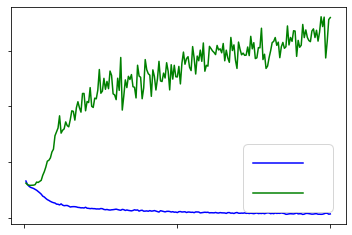

<Figure size 432x288 with 0 Axes>

In [71]:
# plot loss & validation during training
plt.plot(epochs, loss, 'b', label = 'train loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.savefig('Adam_loss_validation.png')

Training loss decreases as expected with more epics. Near 200 epoachs, validation loss starts to stabalize, decreasing little by little.

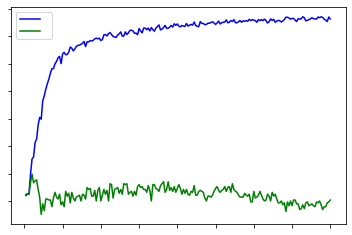

<Figure size 432x288 with 0 Axes>

In [79]:
# plot accuracy during training
accuracy = history.history['acc']
valid_accuracy = history.history['val_acc']

plt.plot(epochs, accuracy, 'b', label = 'train accuracy')
plt.plot(epochs, valid_accuracy, 'g', label = 'validation accuracy')
plt.title('training & validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('Adam_accuracy.png')

Training accuracy increases significantly as epics are added, starting to stabilize around 200 epochs. Validation accuracy dips and continues to increase little by little with more epics.

In [60]:
# evaluate NN on test set
grid_search_2_fit.score(X_test, y_test) # 66% accuracy during test, nearly same as train -- model generalizes well

0.6620521189141351

The model generalizes well as there is only a 0.038 drop in accuracy from training to test.

#### Instance 6

Grid Search w/ Keras Classifier & 5-fold CV (SGD optimization)

In [14]:
# function to create model

def classifier_model2():
    
    # create model
    model = Sequential()
    
    # hidden layer 1
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 166))
    model.add(Dropout(0.1))

    # hidden layer 2
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 3
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 4
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 5
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # output layer
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))
    
    # specify optimization parameters
    sgd = optimizers.SGD(lr = 0.1) # no momentum is used by default
    
    # compile model
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    
    return model

In [15]:
# instantiate keras classifier model -- note that dropout is baked into the model
model2 = KerasClassifier(build_fn = classifier_model2, verbose = 0)

In [16]:
# create grid search parameters

batches2 = [10, 15, 20, 25]
epochs2 = [25, 50, 100, 150, 200]

params2 = dict(batch_size = batches2, epochs = epochs2)

In [17]:
%%time

# instantiate the GridSearchCV object and run search
grid_search_3 = GridSearchCV(estimator = model2, param_grid = params2, n_jobs = -1, cv = 5)

CPU times: user 48 µs, sys: 1 µs, total: 49 µs
Wall time: 52.2 µs


In [18]:
# fit to training data
grid_search_3_fit = grid_search_3.fit(X_train, y_train)

/Users/colella2/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
# summarize results
# best_score is the mean cross-validated score of the best_estimator
print(grid_search_3_fit.best_score_, grid_search_3_fit.best_params_) # 68% model accuracy during train

0.6636395560687461 {'batch_size': 15, 'epochs': 25}


In [20]:
# instantiate model with best parameters as object for plotting
# get model history for plotting
history2 = model2.fit(X_train, y_train, epochs = 25, batch_size = 15, validation_split = 0.2)

In [21]:
# extract metrics of value from model
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(loss2) + 1)

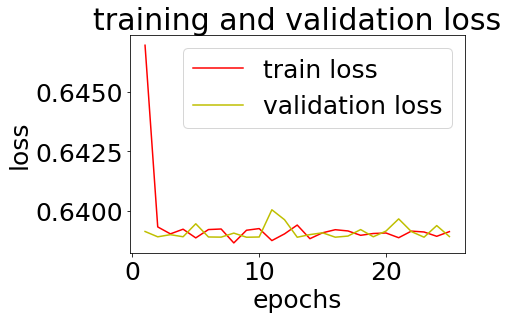

<Figure size 432x288 with 0 Axes>

In [26]:
# plot loss & validation during training
plt.plot(epochs2, loss2, 'r', label = 'train loss')
plt.plot(epochs2, val_loss2, 'y', label = 'validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.savefig('SGD_loss_validation.png')

Training loss decreases as expected with more epics. Near 200 epoachs, validation loss starts to stabalize.

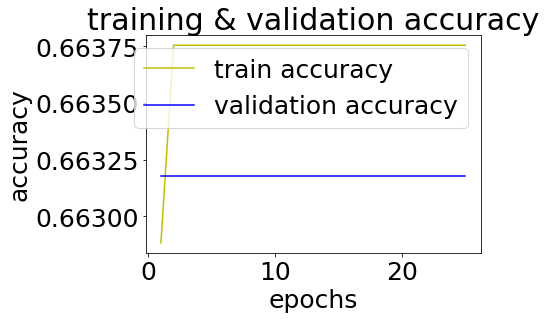

<Figure size 432x288 with 0 Axes>

In [25]:
# plot accuracy during training
accuracy2 = history2.history['acc']
valid_accuracy2 = history2.history['val_acc']

plt.plot(epochs2, accuracy2, 'y', label = 'train accuracy')
plt.plot(epochs2, valid_accuracy2, 'b', label = 'validation accuracy')
plt.title('training & validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('SGD_accuracy.png')

Training accuracy increases around 3 epochs then remains relatively stable. Validation pretty consistent.

In [24]:
# evaluate NN on test set
grid_search_3_fit.score(X_test, y_test) # 65% accuracy during test -- model generalizes well

0.653908812504638

The model generalizes well as there is only a 0.030 drop in accuracy from training to test. This slightly beats previous NN with Adam optimizer.